The optimizer's documentation (KernelML) can be found [here](https://github.com/freedomtowin/kernelml/blob/master/README.md)

In [5]:
#install optimizer
!pip install kernelml
!pip install ray

# Key Elements

We want IC=1mA and we want IE to be approximately equal to IC.

Here is the original problem: https://www.allaboutcircuits.com/textbook/semiconductors/chpt-4/biasing-calculations/


Supporting reference:https://www.electronics-tutorials.ws/amplifier/transistor-biasing.html

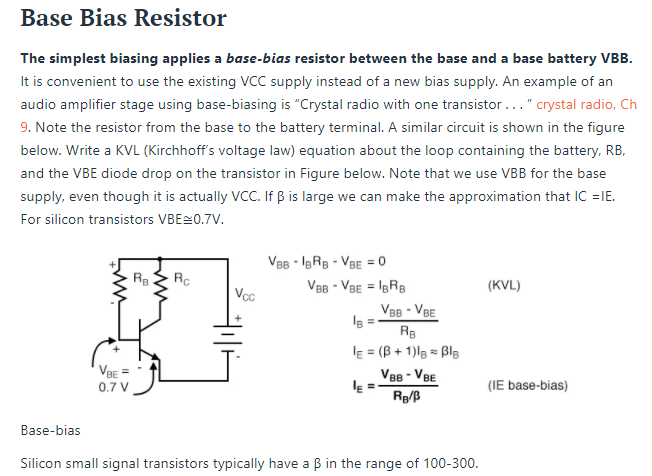

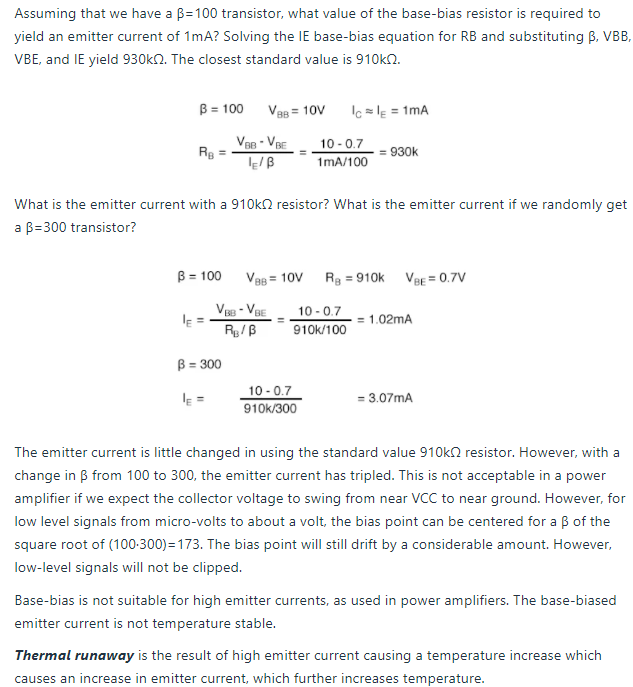

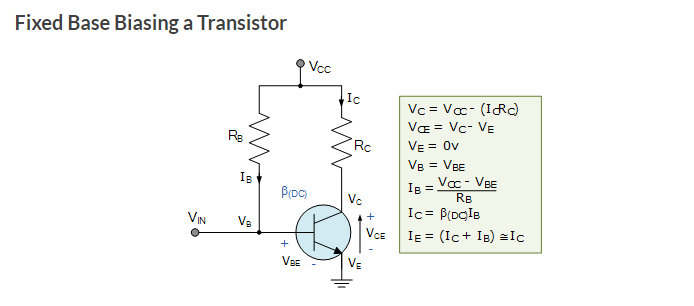

In [7]:
import ray
import kernelml 
import numpy as np

try:
    ray.shutdown()
except:
    pass

ray.init(num_cpus = 1)

X = {"COMPONENT_0":{"VCC":10, 'RB':None,'RC':None, 'VBE':0.7,  'BETA':None}}
y = 1e-3

args=np.array([])

X_id = ray.put(X)
y_id = ray.put(y)
args_id = ray.put(args)


def circuit_loss(X,y,w,args):
    
    VCC =  X['COMPONENT_0']['VCC']
    VBE =  X['COMPONENT_0']['VBE']
    
    
    BETA = np.abs(w[0])
    RB =  np.abs(w[1])
  
    VE = 0

    VB = VBE
    IB = (VCC-VBE)/RB
    
    IC = BETA*IB

    IE = (BETA+1)*IB  
    
    return np.abs(IC-y)  + np.abs(IE-IC)

@ray.remote
def map_losses(X,y,w_list,w_indx,args):
    N = w_indx.shape[0]
    resX = np.zeros(N)
    iter_ = 0
    for i in w_indx:
        loss = circuit_loss(X,y,w_list[:,i:i+1],args)
        resX[iter_] = loss
        iter_+=1
    return resX
    

def ray_parallel_mapper(X,y,w_list,args):
    
    num_cores = 4
    
    weights_index = np.arange(0,w_list.shape[1])
    weights_index_split = np.array_split(weights_index,num_cores)
    
    w_list_id = ray.put(w_list)
    
    result_ids = [map_losses.remote(X_id,y_id,w_list_id,weights_index_split[i],args_id) for i in range(num_cores)]
    result = ray.get(result_ids)
    
    loss = []
    indx = []
    for l in result:
        loss.extend(l)
    loss = np.hstack(loss)
    return loss

def clip_parameter_transform(w,*args):
    # w[rows,columns] = (parameter set,iteration)
    tmp = w.copy()
    #beta
    # tmp[0] = np.clip(tmp[0],90,400)
    # w = tmp
    return np.clip(w,0,np.inf)

zscore=2.0
realizations = 6
cycles = 10
volume = 10
simulations = 100
volatility = 1

def prior_sampler_uniform_distribution(kmldata):
    
    
    random_samples = kmldata.prior_random_samples
    num_params = kmldata.number_of_parameters
    
    BETA = np.random.uniform(low=100,high=300,size=(1,random_samples))
    RB = np.random.uniform(low=100,high=1e5,size=(1,random_samples))
    result=np.vstack([BETA,RB])

    return result

kml0 = kernelml.KernelML(ray_parallel_mapper,
                 prior_sampler_fcn=prior_sampler_uniform_distribution,
                 posterior_sampler_fcn=None,
                 intermediate_sampler_fcn=None,
                 parameter_transform_fcn=clip_parameter_transform,
                 batch_size=None)

kml0.optimize(X,y,
                                number_of_parameters=2,
                                args=[args],
                                number_of_realizations=realizations,
                                number_of_random_simulations =simulations,
                                update_volatility = volatility,
                                number_of_cycles=cycles,
                                update_volume=volume,
                                convergence_z_score=zscore,
                                prior_uniform_low=1,
                                prior_uniform_high=100,
                                print_feedback=True)

kmldata0 = kml0.kmldata

realization 0 loss 6.721928178261036e-05 time 1.718414306640625
realization 1 loss 2.6407833694831913e-05 time 1.648141860961914
realization 2 loss 1.3488088364851112e-05 time 1.6630966663360596
realization 3 loss 1.0500907474723063e-05 time 1.7945058345794678
realization 4 loss 7.964535220305637e-06 time 1.792863130569458
realization 5 loss 7.229914120723867e-06 time 1.7993640899658203


In [8]:
w =  kmldata0.best_weight_vector[0]
VCC =  X['COMPONENT_0']['VCC']
VBE =  X['COMPONENT_0']['VBE']


BETA = np.abs(w[0])
RB =  np.abs(w[1])
VE = 0

VB = VBE
IB = (VCC-VBE)/RB

IC = BETA*IB

In [9]:
IC

0.0010002189682267416

In [11]:
BETA, RB//1000 #K Ohm

(142.665338365436, 1326.0)